# pySCENIC protocol

May 2019

In [4]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE

/usr/local/lib/python3.6/site-packages/louvain/Optimiser.py:349: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(issubclass(partition_type, LinearResolutionParameterVertexPartition),


In [5]:
# set variables for file paths to read from and write to:

# set a working directory
wdir = "/ddn1/vol1/staging/leuven/stg_00002/lcb/cflerin/testruns/scenic-protocol/prottest2/"
os.chdir( wdir )

# path to unfiltered loom file (this will be created in the optional steps below)
# f_loom_path_unfilt = "/ddn1/vol1/staging/leuven/stg_00002/lcb/cflerin/analysis/pbmc10k/pbmc10k_unfiltered.loom" # complete pbmc10k data
# f_loom_path_unfilt = "/ddn1/vol1/staging/leuven/stg_00002/lcb/cflerin/testruns/scenic-protocol/pbmc10k_filtered_n500.loom" # test dataset, n=500 cells
f_loom_path_unfilt = "pbmc10k_unfiltered.loom" # test dataset, n=500 cells

# # path to loom file with basic filtering applied (this will be created in the "initial filtering" step below). Optional.
f_loom_path_scenic = "pbmc10k_filtered_scenic.loom"

# path to anndata object, which will be updated to store Scanpy results as they are generated below
f_anndata_path = "anndata.h5ad"

# path to pyscenic output
# f_pyscenic_output = "pyscenic_output.loom"

# loom output, generated from a combination of Scanpy and pySCENIC results:
# f_final_loom = "SCENIC-protocol_final.loom"

In [6]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=120)

scanpy==1.4.3 anndata==0.6.20 umap==0.3.9 numpy==1.16.2 scipy==1.2.1 pandas==0.23.4 scikit-learn==0.20.3 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


## Expression data import
There are several ways to import expression data. For simplicity we focus on getting the data into a Scanpy anndata object or a loom file.  Scanpy provides functions for reading in a wide variety of formats (described [here](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/index.html#reading)).

### Reading in expression data: 10x Genomics mtx files

In [4]:
f_mtx_dir = '/ddn1/vol1/staging/leuven/stg_00002/lcb/cflerin/data/public/pbmc_10k_v3/filtered_feature_bc_matrix/'

adata = sc.read_10x_mtx(
    f_mtx_dir ,                 # the directory with the `.mtx` file
    var_names='gene_symbols',   # use gene symbols for the variable names (variables-axis index)
    cache=False) 

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


### Reading in expression data: from a text file

In [ ]:
f_exprMat = '/ddn1/vol1/staging/leuven/stg_00002/lcb/cflerin/testruns/pbmc8k/pbmc8k_countMat_filtered.tsv'

adata = sc.read_text( f_exprMat, delimiter='\t', first_column_names=True )

### write to an unfiltered loom file

Here, we use the loompy functions directly

In [5]:
row_attrs = { 
    "Gene": np.array(adata.var.index) ,
}
col_attrs = { 
    "CellID":  np.array(adata.obs.index) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}

lp.create( f_loom_path_unfilt, adata.X.transpose(), row_attrs, col_attrs )

## Initial/basic filtering

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# read unfiltered data from a loom file
adata = sc.read_loom( f_loom_path_unfilt )

In [8]:
nCountsPerGene = np.sum(adata.X, axis=0)
nCellsPerGene = np.sum(adata.X>0, axis=0)

# Show info
print("Number of counts (in the dataset units) per gene:", nCountsPerGene.min(), " - " ,nCountsPerGene.max())
print("Number of cells in which each gene is detected:", nCellsPerGene.min(), " - " ,nCellsPerGene.max())

Number of counts (in the dataset units) per gene: 0.0  -  3567008.0
Number of cells in which each gene is detected: 0  -  11766


In [9]:
nCells=adata.X.shape[0]

# pySCENIC thresholds
minCountsPerGene=3*.01*nCells # 3 counts in 1% of cells
print("minCountsPerGene: ", minCountsPerGene)

minSamples=.01*nCells # 1% of cells
print("minSamples: ", minSamples)

minCountsPerGene:  353.07
minSamples:  117.69


In [10]:
# simply compute the number of genes per cell (computers 'n_genes' column)
sc.pp.filter_cells(adata, min_genes=0)
# mito and genes/counts cuts
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

Diagnostic plots

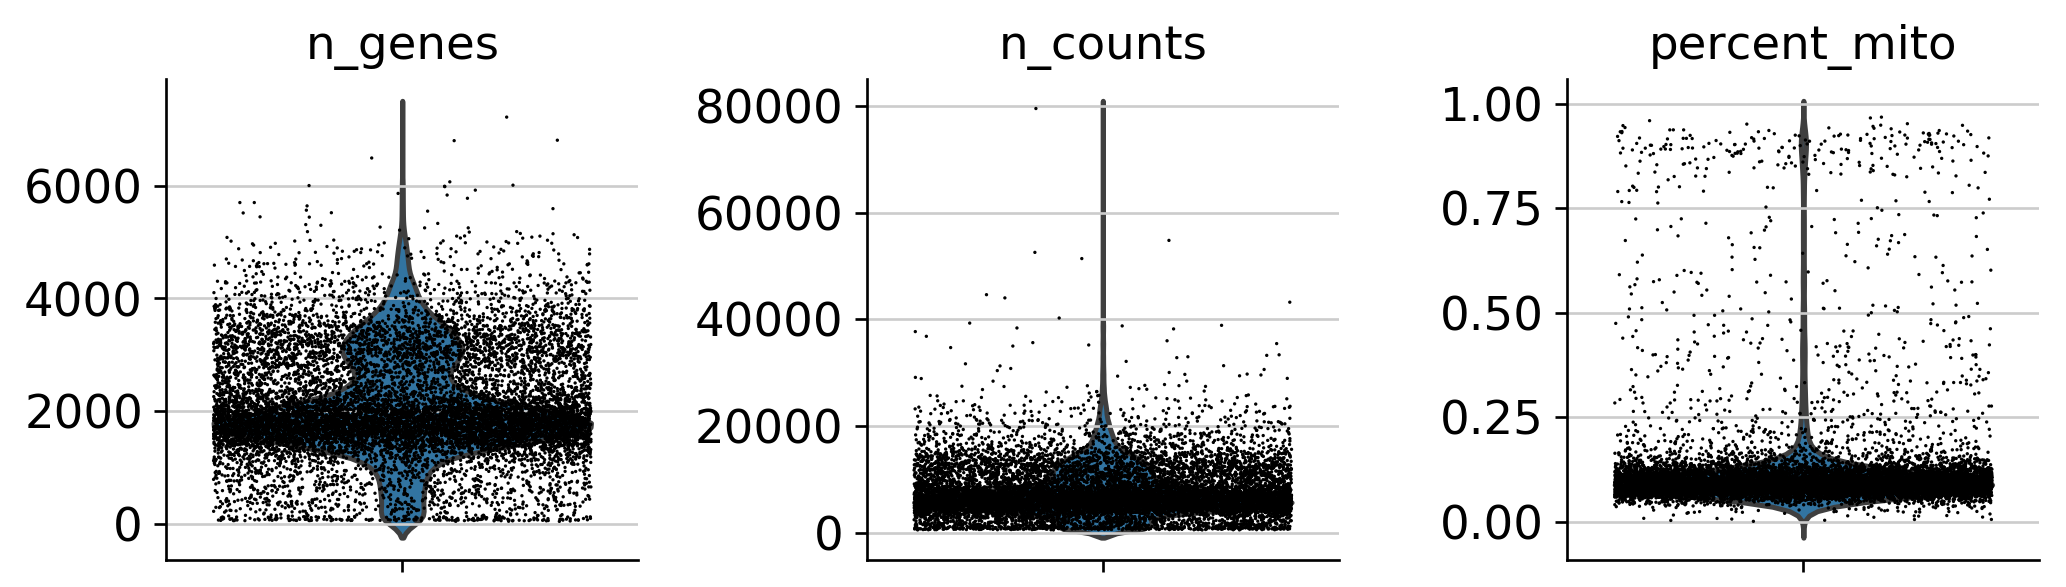

In [11]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
    jitter=0.4, multi_panel=True )

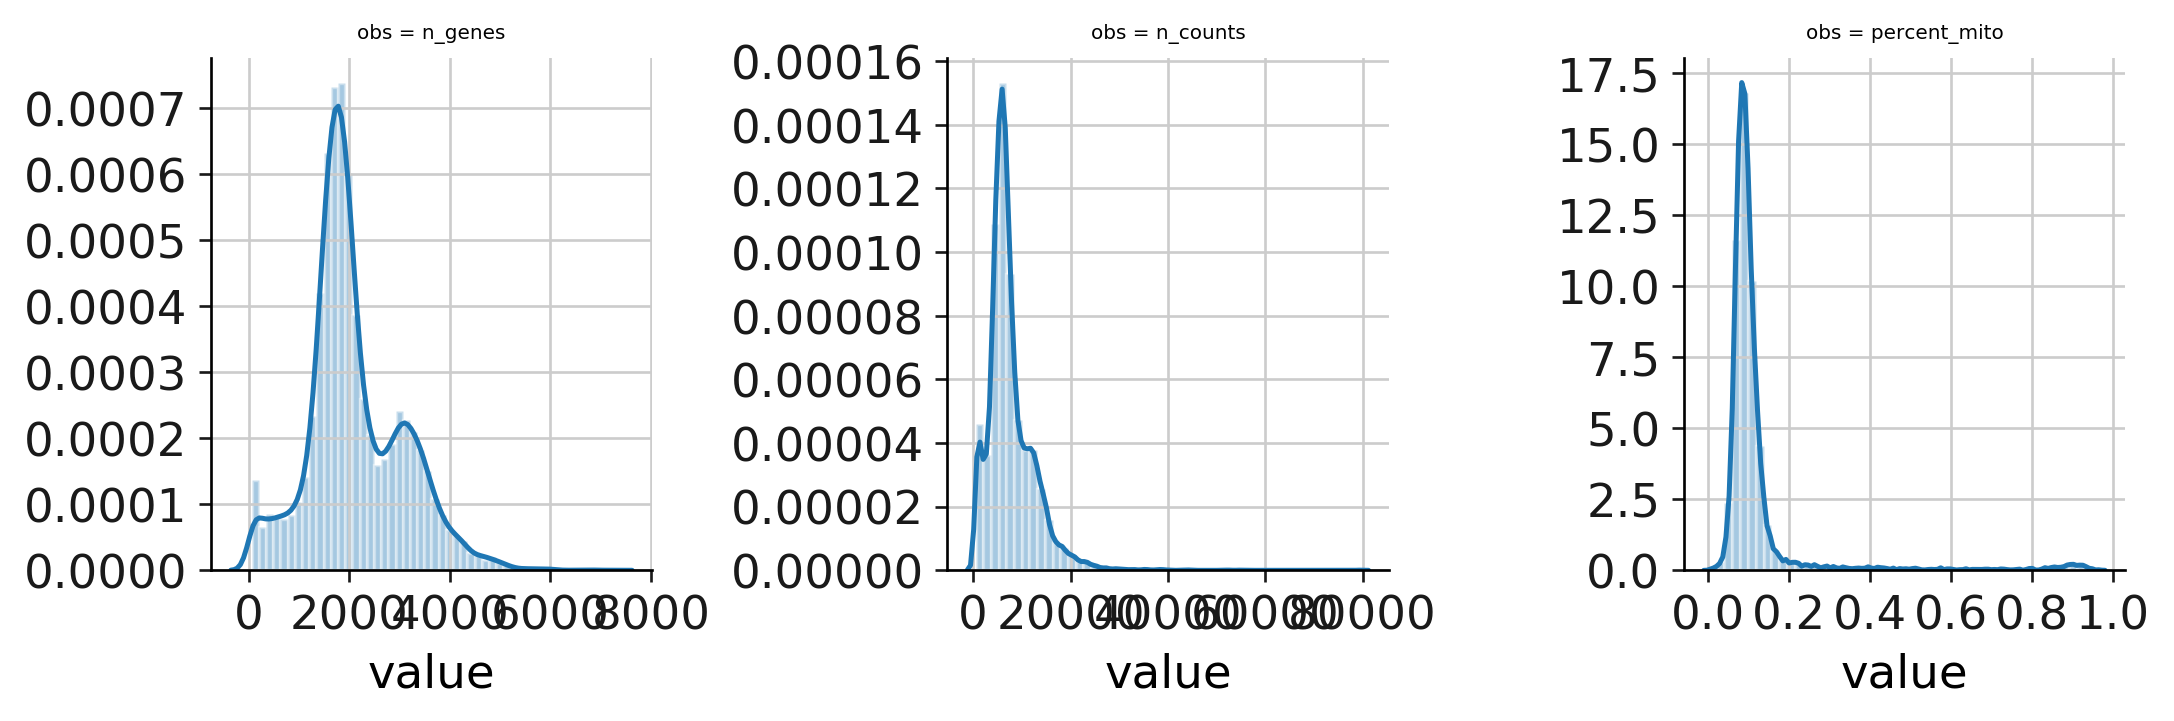

In [12]:
tp = adata.obs.melt(var_name="obs")
g = sns.FacetGrid(tp, col="obs", col_wrap=4, sharex=False,sharey=False, col_order=['n_genes', 'n_counts', 'percent_mito'] )
#g.set_xticklabels(rotation=30)
#plt.xticks(rotation=45)
sns.set(font_scale=0.5)
#for ax in g.axes:
#    l = ax.get_xlabel()
#    ax.set_xlabel(l, fontsize=25)
g.map(sns.distplot, "value")

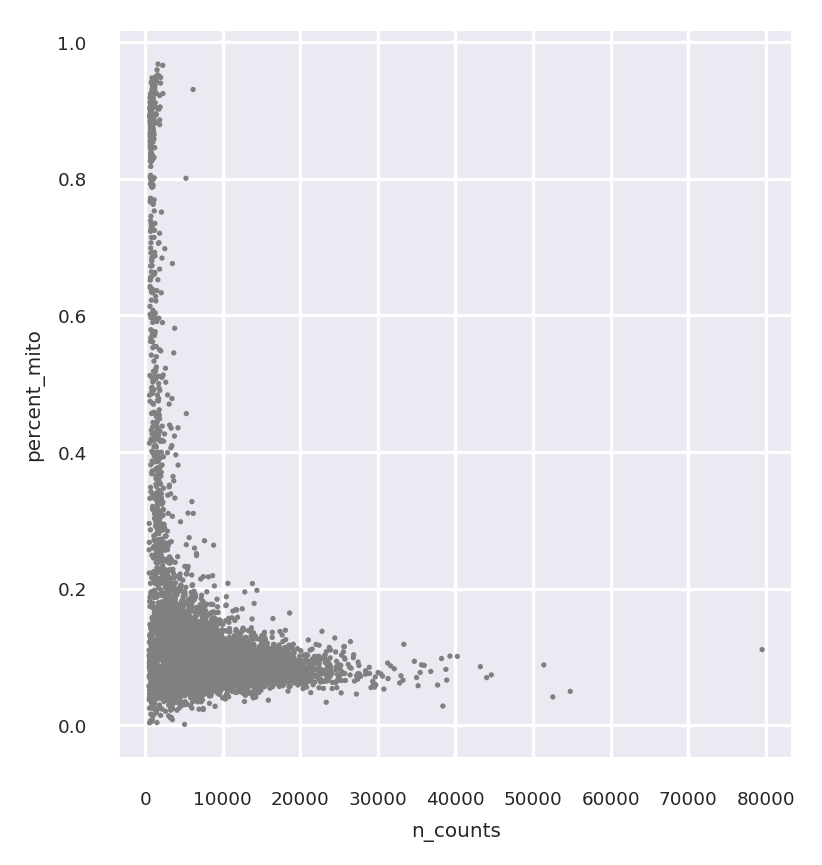

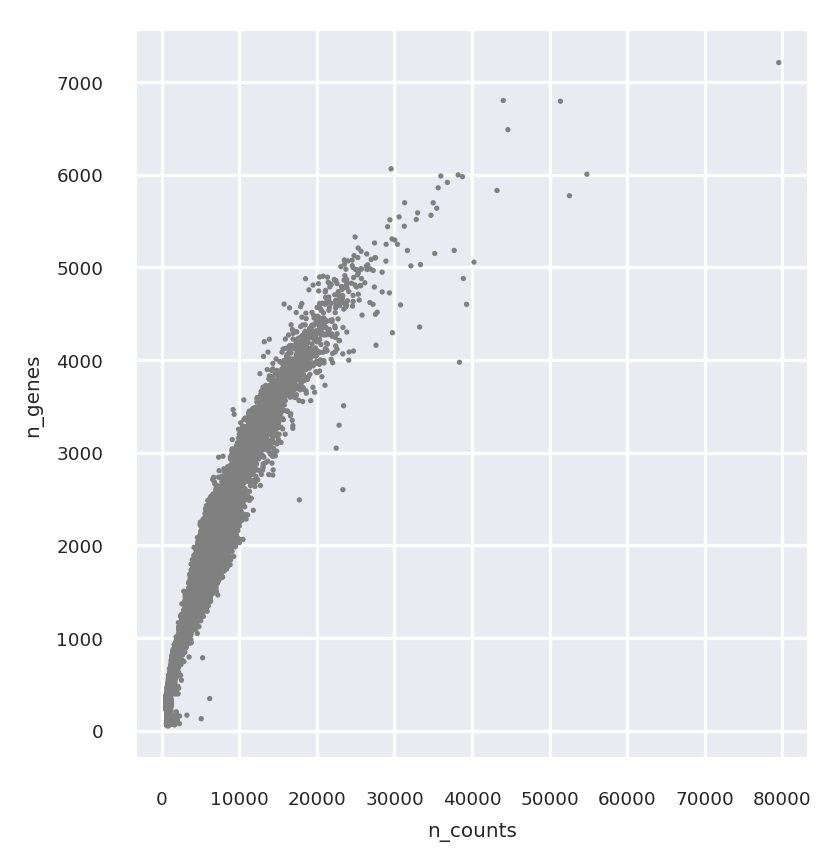

In [13]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

Carry out the filtering steps:

In [14]:
####################
# initial cuts
sc.pp.filter_cells(adata, min_genes=200 )
sc.pp.filter_genes(adata, min_cells=3 )

filtered out 232 cells that have less than 200 genes expressed
filtered out 13246 genes that are detected in less than 3 cells


In [15]:
adata = adata[adata.obs['n_genes'] < 4000, :]
adata = adata[adata.obs['percent_mito'] < 0.15, :]

Diagnostic plots, post filtering

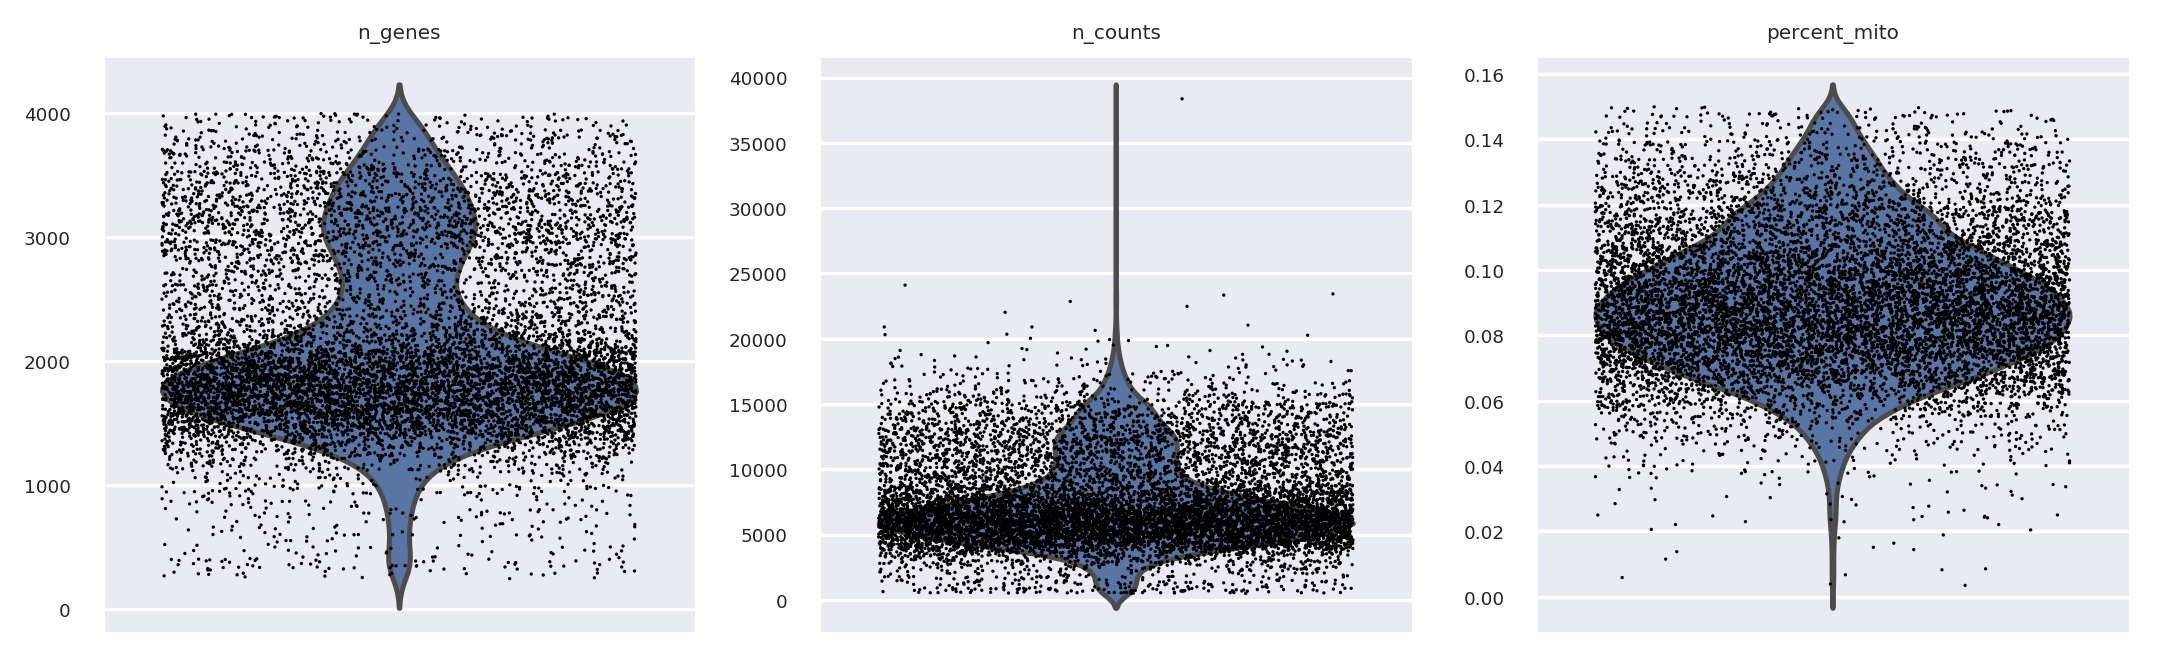

In [16]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
    jitter=0.4, multi_panel=True )

Update the anndata file, to be used for further processing, clustering, visualization, etc..

In [17]:
adata.write( f_anndata_path )

Output the basic filtered expression matrix to a loom file.  

This can also be used in the command-line pySCENIC steps, for example, or as an input to the Nextflow pipeline.

In [18]:
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata.obs_names) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}
lp.create( f_loom_path_scenic, adata.X.transpose(), row_attrs, col_attrs)

## Further pre-processing of expression data

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


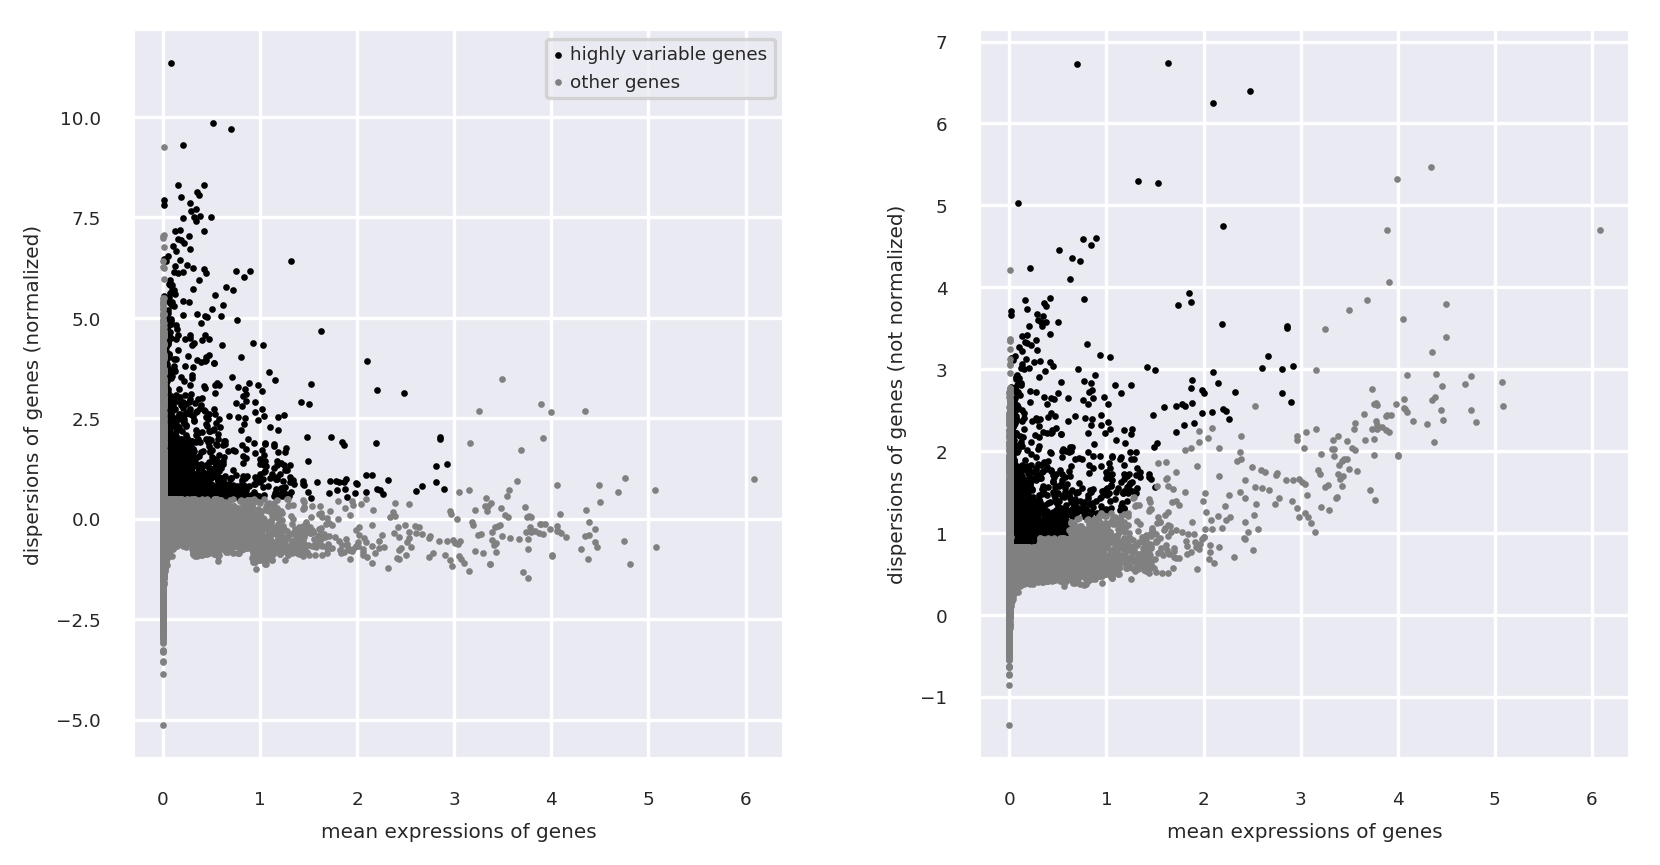

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:14.96)


In [19]:
# Total-count normalize (library-size correct) to 10,000 reads/cell
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# log transform the data.
sc.pp.log1p(adata)

# save a copy of the raw data
adata.raw = adata

# identify highly variable genes.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

# keep only highly variable genes:
adata = adata[:, adata.var['highly_variable']]

# regress out total counts per cell and the percentage of mitochondrial genes expressed
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'] ) #, n_jobs=args.threads)

# scale each gene to unit variance, clip values exceeding SD 10.
sc.pp.scale(adata, max_value=10)

# update the anndata file:
adata.write( f_anndata_path )

### 1 PCA

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:01.12)


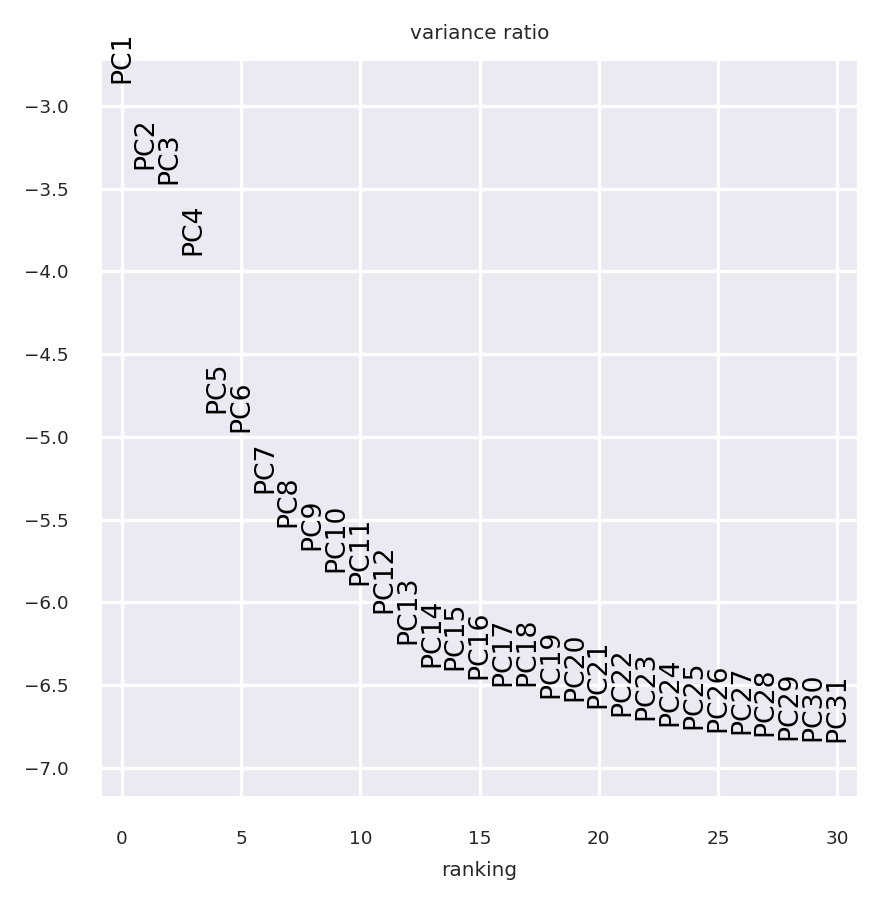

In [20]:
# adata = sc.read_h5ad( f_anndata_path )
# principal component analysis
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)
adata.write( f_anndata_path )

### 1b PCA component selection

In [ ]:
# TODO

### 2 Visualization of highly variable genes

In [21]:
# neighborhood graph of cells (determine optimal number of PCs here)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)
# compute UMAP
sc.tl.umap(adata)
# tSNE
tsne = TSNE( n_jobs=20 )
adata.obsm['X_tsne'] = tsne.fit_transform( adata.X )
adata.write( f_anndata_path )

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:05.85) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP
    using 'X_pca' with n_pcs = 40
    finished (0:00:12.17) --> added
    'X_umap', UMAP coordinates (adata.obsm)


### 3 Clustering

running Louvain clustering
    using the "louvain" package of Traag (2017)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

    finished (0:00:00.92) --> found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


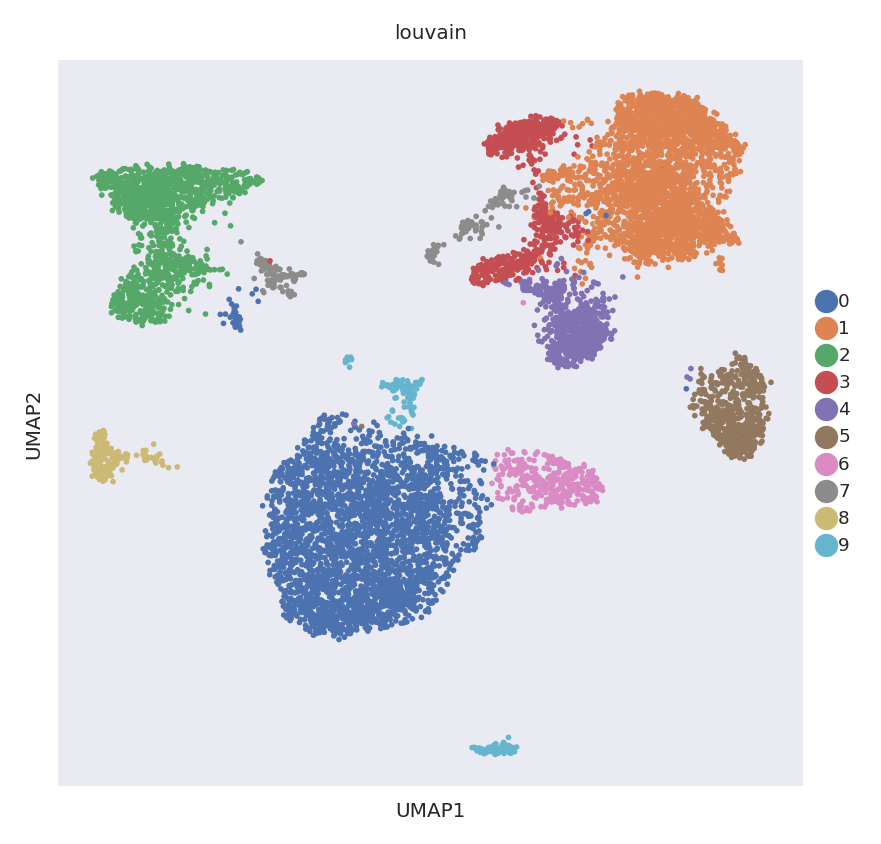

In [22]:
# cluster the neighbourhood graph
sc.tl.louvain(adata,resolution=0.3)

sc.pl.umap(adata, color=['louvain'] )

ranking genes


/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


    finished (0:00:05.59) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


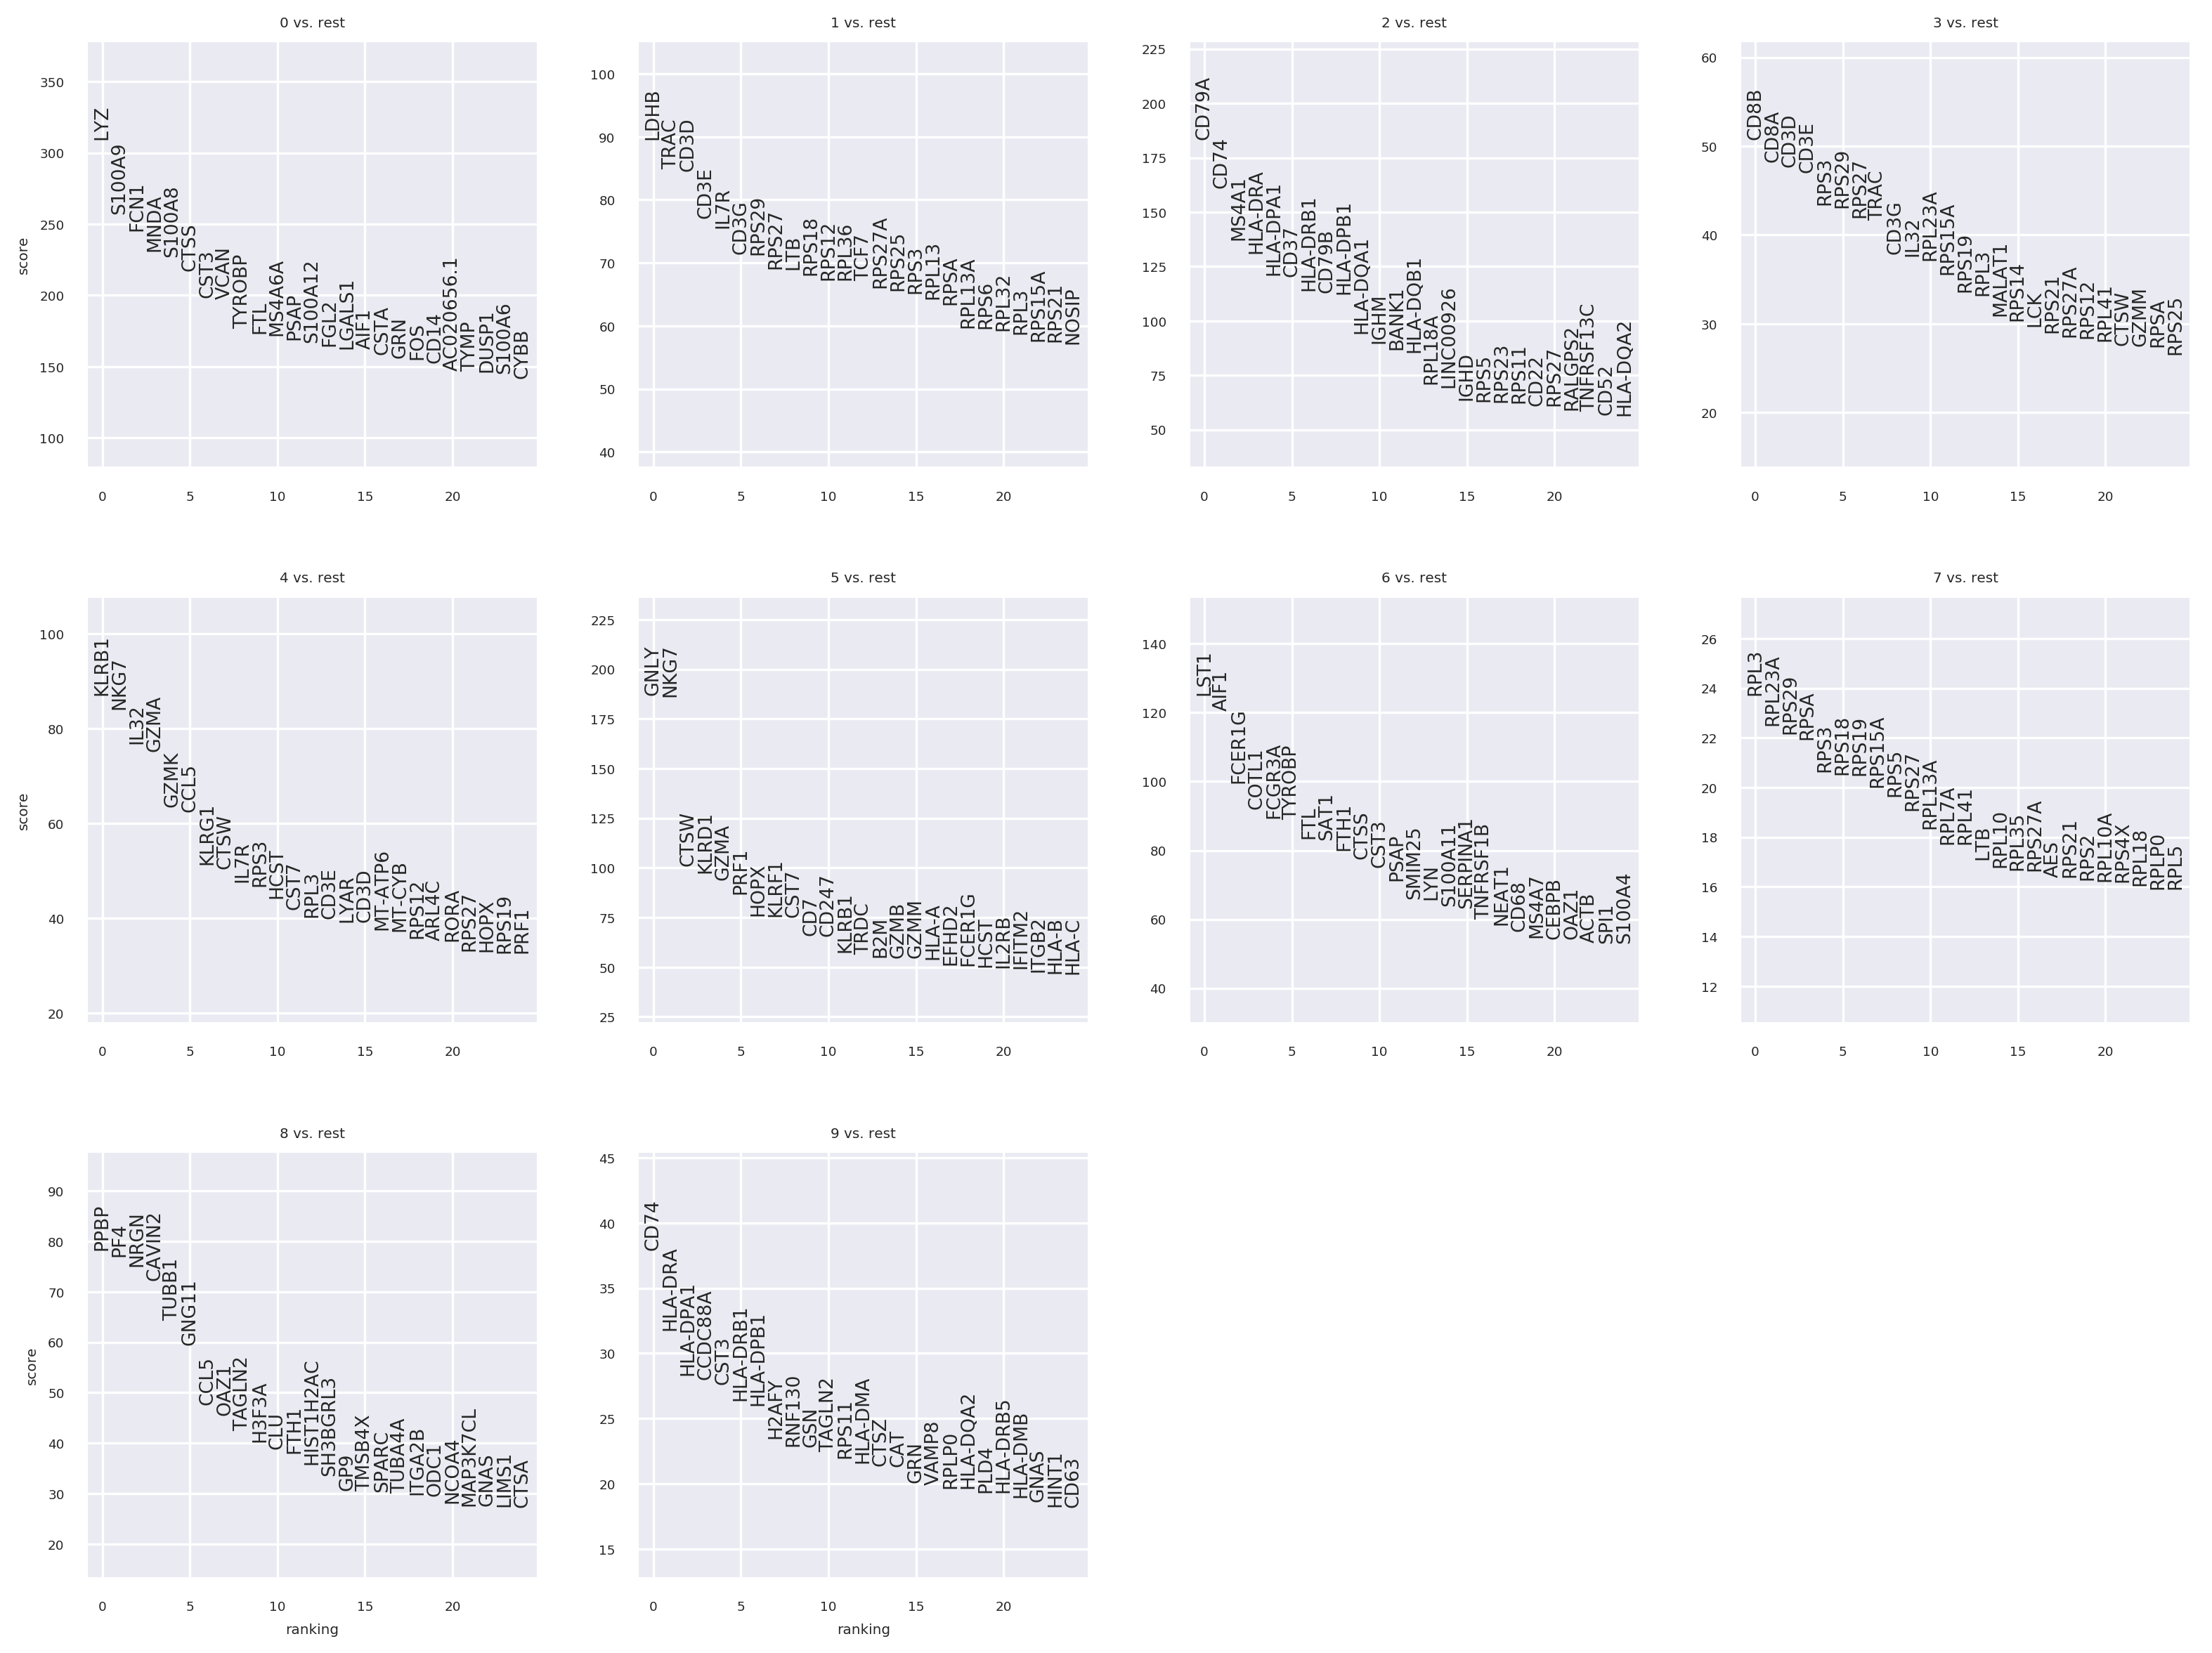

In [23]:
# find marker genes
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

# sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)
adata.write( f_anndata_path )

## SCENIC steps

### Phase I: Gene regulatory network inference, and generation of co-expression modules

#### Phase Ia: GRN inference using the GRNBoost2 algorithm

In [1]:
from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2
from dask.distributed import LocalCluster, Client

/usr/local/lib/python3.6/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


import transcription factors list

In [2]:
f_tfs = "/ddn1/vol1/staging/leuven/stg_00002/lcb/cflerin/resources/allTFs_hg38.txt" # human
# f_tfs = "/ddn1/vol1/staging/leuven/stg_00002/lcb/cflerin/resources/allTFs_dmel.txt" # drosophila
# f_tfs = "/ddn1/vol1/staging/leuven/stg_00002/lcb/cflerin/resources/allTFs_mm.txt"   # mouse

tf_names = load_tf_names( f_tfs )

Get the counts matrix (without log transformation or further processing) from the loom file we wrote earlier:

In [7]:
lf = lp.connect( f_loom_path_scenic, mode='r', validate=False )
exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID ).T
lf.close()

run the GRN inference step (this can take some time)

In [28]:
# threads_per_worker should always be set to 1. Use n_workers to change the number of processes that dask will use
local_cluster = LocalCluster(n_workers=20, threads_per_worker=1) 
client = Client(local_cluster)
adjacencies = grnboost2(
    expression_data=exprMat,
    tf_names=tf_names,
    verbose=True,
    client_or_address=client)

preparing dask client
parsing input
creating dask graph


/usr/local/lib/python3.6/site-packages/arboreto/algo.py:214: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  expression_matrix = expression_data.as_matrix()


20 partitions
computing dask graph
not shutting down client, client was created externally
finished


In [29]:
client.close()
local_cluster.close()

In [11]:
adjacencies.head()

,TF,target,importance
0,TBX21,NKG7,219.412288
1,RPS4X,RPL10A,216.485291
2,RPS4X,RPL39,214.191076
3,RPS4X,RPL32,212.309751
4,RPS4X,RPS3A,212.084918


save the adjacencies matrix:

In [31]:
adjacencies.to_csv("adj.csv", index=False, sep='\t')

#### Phase Ib: Derive potential regulomes from co-expression modules

Regulons are derived from adjacencies based on three methods.

The first method to create the TF-modules is to select the best targets for each transcription factor:

1. Targets with importance > the 50th percentile.
2. Targets with importance > the 75th percentile
3. Targets with importance > the 90th percentile.

The second method is to select the top targets for a given TF:

1. Top 50 targets (targets with highest weight)

The alternative way to create the TF-modules is to select the best regulators for each gene (this is actually how GENIE3 internally works). Then, these targets can be assigned back to each TF to form the TF-modules. In this way we will create three more gene-sets:

1. Targets for which the TF is within its top 5 regulators
2. Targets for which the TF is within its top 10 regulators
3. Targets for which the TF is within its top 50 regulators

A distinction is made between modules which contain targets that are being activated and genes that are being repressed. Relationship between TF and its target, i.e. activator or repressor, is derived using the original expression profiles. The Pearson product-moment correlation coefficient is used to derive this information.

In addition, the transcription factor is added to the module and modules that have less than 20 genes are removed.

In [12]:
import glob
from pyscenic.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies
from pyscenic.prune import prune2df, df2regulons

load ranking databases:

In [13]:
f_db_glob = "/ddn1/vol1/staging/leuven/res_00001/databases/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc9nr/gene_based/*feather"

db_fnames = glob.glob(f_db_glob)
def name(fname):
    return os.path.basename(fname).split(".")[0]
dbs = [RankingDatabase(fname=fname, name=name(fname)) for fname in db_fnames]
dbs

[FeatherRankingDatabase(name="hg38__refseq-r80__10kb_up_and_down_tss"),
 FeatherRankingDatabase(name="hg38__refseq-r80__500bp_up_and_100bp_down_tss")]

From the GRN output, create an initial set of modules/regulons which will be pruned in subsequent steps:

In [14]:
modules = list(modules_from_adjacencies(adjacencies, exprMat))

/usr/local/lib/python3.6/site-packages/pyscenic/utils.py:138: RuntimeWarning: invalid value encountered in greater
  regulations = (rhos > rho_threshold).astype(int) - (rhos < -rho_threshold).astype(int)
/usr/local/lib/python3.6/site-packages/pyscenic/utils.py:138: RuntimeWarning: invalid value encountered in less
  regulations = (rhos > rho_threshold).astype(int) - (rhos < -rho_threshold).astype(int)


### Phase II: Prune modules for targets with cis regulatory footprints (aka cisTarget)

In [15]:
f_motif_path = "/ddn1/vol1/staging/leuven/res_00001/databases/cistarget/motif2tf/motifs-v9-nr.hgnc-m0.001-o0.0.tbl"

In [16]:
df = prune2df(dbs, modules, f_motif_path )
#, num_workers=20)  

Less than 80% of the genes in Regulon for TCEAL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss. Skipping this module.
Less than 80% of the genes in Regulon for ZNF300 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss. Skipping this module.
Less than 80% of the genes in Regulon for MYPOP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss. Skipping this module.
Less than 80% of the genes in Regulon for ZNF564 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss. Skipping this module.
Less than 80% of the genes in Regulon for ZNF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss. Skipping this module.
Less than 80% of the genes in Regulon for UBE2V1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss. Skipping this module.
Less than 80% of the genes in Regulon for ZNF771 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss. Skipping this module.
Less than 80% of the genes in Regulon for EDN1 could be mapped to hg38__refseq-r80__10kb_up_a

In [17]:
# df.to_csv(MOTIFS_FNAME)
regulons = df2regulons(df)

### Phase III: Cellular regulon enrichment matrix (AUCell)

Characterize the different cells in a single-cell transcriptomics experiment by the enrichment of the regulons. Enrichment of a regulon is measures as AUC of the recovery curve of the genes that define this regulon.

In [18]:
from pyscenic.aucell import aucell
import umap
from pyscenic.cli.utils import append_auc_mtx

In [19]:
auc_mtx = aucell(exprMat, regulons, num_workers=1)
auc_mtx.to_csv('auc_mtx.csv')

100%|██████████| 389/389 [00:20<00:00, 33.26it/s]


Append all of the scenic results to the previously created loom file

In [20]:
append_auc_mtx( f_loom_path_scenic , auc_mtx, regulons)

### Visualization of SCENIC's AUC matrix

In [21]:
# UMAP
runUmap = umap.UMAP(n_neighbors=10, min_dist=0.4, metric='correlation').fit_transform
dr_umap = runUmap( auc_mtx )
pd.DataFrame(dr_umap, columns=['X', 'Y'], index=exprMat.index).to_csv( "scenic_umap.txt", sep='\t')
# tSNE
tsne = TSNE( n_jobs=20 )
dr_tsne = tsne.fit_transform( auc_mtx )
pd.DataFrame(dr_tsne, columns=['X', 'Y'], index=exprMat.index).to_csv( "scenic_tsne.txt", sep='\t')

## Integrate the output

Here, we combine the results from SCENIC and the Scanpy analysis into a SCope-compatible loom file

In [22]:
import zlib
import base64

In [23]:
# scenic output
lf = lp.connect( f_loom_path_scenic, mode='r+', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
regulons = lf.ra.Regulons
dr_umap = pd.read_csv( 'scenic_umap.txt', sep='\t', header=0, index_col=0 )
dr_tsne = pd.read_csv( 'scenic_tsne.txt', sep='\t', header=0, index_col=0 )
###

Fix regulon objects to display properly in SCope:

In [25]:
auc_mtx.columns = auc_mtx.columns.str.replace('\(','_(')
regulons.dtype.names = tuple( [ x.replace("(","_(") for x in regulons.dtype.names ] )
# regulon thresholds
rt = meta['regulonThresholds']
for i,x in enumerate(rt):
    tmp = x.get('regulon').replace("(","_(")
    x.update( {'regulon': tmp} )

Concatenate embeddings (tSNE, UMAP, etc.)

In [28]:
tsneDF = pd.DataFrame(adata.obsm['X_tsne'], columns=['_X', '_Y'])

Embeddings_X = pd.DataFrame( index=lf.ca.CellID )
Embeddings_X = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[0] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[0] ,
        dr_tsne['X'] ,
        dr_umap['X']
    ], sort=False, axis=1, join='outer' )
Embeddings_X.columns = ['1','2','3','4']

Embeddings_Y = pd.DataFrame( index=lf.ca.CellID )
Embeddings_Y = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[1] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[1] ,
        dr_tsne['Y'] ,
        dr_umap['Y']
    ], sort=False, axis=1, join='outer' )
Embeddings_Y.columns = ['1','2','3','4']

Metadata:

In [29]:
pc_to_use = 2

### metadata
metaJson = {}

metaJson['embeddings'] = [
    {
        "id": -1,
        "name": f"Scanpy t-SNE (highly variable genes) {pc_to_use}PCs"
    },
    {
        "id": 1,
        "name": f"Scanpy UMAP  (highly variable genes) {pc_to_use}PCs"
    },
    {
        "id": 2,
        "name": "Scanpy PC1/PC2"
    },
    {
        "id": 3,
        "name": "SCENIC AUC t-SNE"
    },
    {
        "id": 4,
        "name": "SCENIC AUC UMAP"
    },
]

metaJson["clusterings"] = [{
            "id": 0,
            "group": "Scanpy",
            "name": "Scanpy louvain default resolution",
            "clusters": [],
        }]

metaJson["metrics"] = [
        {
            "name": "nUMI"
        }, {
            "name": "nGene"
        }, {
            "name": "Percent_mito"
        }
]

metaJson["annotations"] = [
    #{
    #    "name": "Genotype",
    #    "values": list(set(adata.obs['Genotype'].values))
    #},
    #{
    #    "name": "Timepoint",
    #    "values": list(set(adata.obs['Timepoint'].values))
    #},
    #{
    #    "name": "Sample",
    #    "values": list(set(adata.obs['Sample'].values))
    #}
]

# SCENIC regulon thresholds:
metaJson["regulonThresholds"] = rt

for i in range(max(set([int(x) for x in adata.obs['louvain']])) + 1):
    clustDict = {}
    clustDict['id'] = i
    clustDict['description'] = f'Unannotated Cluster {i + 1}'
    metaJson['clusterings'][0]['clusters'].append(clustDict)
    
clusterings = pd.DataFrame()
clusterings["0"] = adata.obs['louvain'].values.astype(np.int64)

Assemble loom file row and column attributes

In [30]:
def dfToNamedMatrix(df):
    arr_ip = [tuple(i) for i in df.values]
    dtyp = np.dtype(list(zip(df.dtypes.index, df.dtypes)))
    arr = np.array(arr_ip, dtype=dtyp)
    return arr

In [31]:
col_attrs = {
    "CellID": np.array(adata.obs.index),
    "nUMI": np.array(adata.obs['n_counts'].values),
    "nGene": np.array(adata.obs['n_genes'].values),
    #"Genotype": np.array(adata.obs['Genotype'].values),
    #"Timepoint": np.array(adata.obs['Timepoint'].values),
    #"Sample": np.array(adata.obs['Sample'].values),
    "Percent_mito": np.array(adata.obs['percent_mito'].values),
    "Embedding": dfToNamedMatrix(tsneDF),
    "Embeddings_X": dfToNamedMatrix(Embeddings_X),
    "Embeddings_Y": dfToNamedMatrix(Embeddings_Y),
    "RegulonsAUC": dfToNamedMatrix(auc_mtx),
    "Clusterings": dfToNamedMatrix(clusterings),
    "ClusterID": np.array(adata.obs['louvain'].values)
}

row_attrs = {
    "Gene": lf.ra.Gene,
    "Regulons": regulons,
}

attrs = {
    "title": "sampleTitle",
    "MetaData": json.dumps(metaJson),
    "Genome": 'hg38',
    "SCopeTreeL1": "",
    "SCopeTreeL2": "",
    "SCopeTreeL3": ""
}

# compress the metadata field:
attrs['MetaData'] = base64.b64encode(zlib.compress(json.dumps(metaJson).encode('ascii'))).decode('ascii')

Finally, write the loom file to disk, appending to the scenic output:

In [32]:
lf.ca = col_attrs
lf.ra = row_attrs
#lf.attrs = attrs
for vals in attrs:
    lf.attrs[vals] = attrs[vals]
lf.close()

Optionally, create a new loom file, copying the expression matrix from the open loom connection:

In [53]:
# from shutil import copyfile

f_loom_path_scenic2 = 'pbmc10k_scenic_integrated-output.loom'
# copyfile(f_loom_path_scenic, f_loom_path_scenic2 )

lf = lp.connect( f_loom_path_scenic, mode='r', validate=False )

lp.create(
    filename = f_loom_path_scenic2 ,
    layers=lf[:,:],
    row_attrs=row_attrs, 
    col_attrs=col_attrs, 
    file_attrs=attrs
)
lf.close()

This loom file can now be imported into [SCope](http://scope.aertslab.org/).